# Final Project Report: Quick, Draw! Animal Image Classification

## Introduction

In this project, we explore a unique and fascinating dataset from Quick, Draw!, an online game developed by Google. The game challenges players to draw objects belonging to a specific category within a short time limit. These doodles, contributed by over 15 million players worldwide, form a rich dataset ideal for training neural networks and conducting various analyses.

Our focus is on the subset of this dataset containing animal drawings. We aim to build a deep learning model to classify these sketches accurately into their respective animal categories.

## Reference Material

https://quickdraw.withgoogle.com/data

## Libraries and Setup

Firstly, let's import all the necessary libraries and set up the environment for our analysis and modeling.

In [1]:
import os
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

## Data Acquisition and Preprocessing

The dataset is sourced from the Quick, Draw! dataset, available publicly for download. We specifically focus on a selected list of animal categories. Each category's data is stored in a `.npy` file format, which we download and load into our environment.

### Downloading and Loading Data

In [2]:
# Google Colab check
def is_running_on_colab():
    try:
        cfg = get_ipython().config
        return "google.colab" in str(cfg)
    except NameError:
        return False

# Set base directory
if is_running_on_colab():
    print("Running on Google Colab.")
    # Import drive only if in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    # Ask for user input for the directory
    base_data_dir = input("Enter the directory path in Google Drive where you want to save or load the data (e.g., '/content/drive/My Drive/PROJECT_FOLDER'): ")
else:
    print("Not running on Google Colab.")
    base_data_dir = os.getcwd()

print("Base data directory is set to:", base_data_dir)

Running on Google Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the directory path in Google Drive where you want to save or load the data (e.g., '/content/drive/My Drive/PROJECT_FOLDER'): /content/drive/MyDrive/Final_5511
Base data directory is set to: /content/drive/MyDrive/Final_5511


In [3]:
data_dir = os.path.join(base_data_dir, 'quick_draw_data')

# create data directory
os.makedirs(data_dir, exist_ok=True)
print(f"Directory verified/created: {data_dir}")

Directory verified/created: /content/drive/MyDrive/Final_5511/quick_draw_data


In [4]:
# List of animal categories to evaluate
animal_categories = [
    'ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
    'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish', 'flamingo','frog',
    'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion', 'lobster', 'monkey',
    'mosquito', 'mouse', 'octopus', 'owl', 'panda', 'parrot', 'penguin', 'pig',
    'rabbit', 'raccoon', 'rhinoceros', 'scorpion', 'sea turtle', 'shark', 'sheep',
    'snail', 'snake', 'spider', 'squirrel', 'swan', 'tiger', 'whale', 'zebra'
]

# Base URL for downloading the .npy files
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

# Function to download a file
def download_file(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed to download: {url}")

# Iterate over animal categories and download each .npy file
for category in animal_categories:
    # Construct the URL and filename
    url = base_url + f'{category}.npy'
    filename = os.path.join(data_dir, f'{category}.npy')

    # Check if the file already exists
    if not os.path.exists(filename):
        # Download the file
        download_file(url, filename)


1. **Check Execution Environment**:
   - The function `is_running_on_colab()` checks if the Python script is running on Google Colab. It uses a try-except block to determine the execution environment based on the IPython configuration.

2. **Set Up Base Directory**:
   - Depending on the execution environment (Google Colab or not), the base directory for data storage and retrieval is set.
   - If running on Google Colab, it mounts the Google Drive and prompts the user to input the directory path in Google Drive for data storage.
   - If not running on Google Colab, it sets the base directory to the current working directory of the script.

3. **Data Directory Initialization**:
   - A subdirectory named 'quick_draw_data' within the base directory is created to store the data. The `os.makedirs()` function ensures that the directory is created if it doesn’t already exist.

4. **Define Animal Categories**:
   - A list named `animal_categories` is defined, containing the names of various animals. These names correspond to the categories of drawings that will be downloaded and analyzed.

5. **Set Up URL for Data Download**:
   - The `base_url` variable is set to the URL where the `.npy` files for the Quick, Draw! dataset are hosted.

6. **Download Functionality**:
   - The function `download_file(url, filename)` is defined to download a file from the given URL and save it with the specified filename.
   - It checks the HTTP response status to confirm a successful download or prints a failure message if not successful.

7. **Downloading Data**:
   - The script iterates over each animal category in the `animal_categories` list.
   - For each category, it constructs a URL for the `.npy` file and sets a filename for saving the file.
   - It checks if the file already exists in the local directory to avoid re-downloading.
   - If the file doesn’t exist, it calls `download_file()` to download and save the data file.drawings), and downloading this data for future analysis and modeling.

### Exploratory Data Analysis (EDA)

We perform an exploratory analysis to understand the dataset's structure, such as class distribution, average sketches, and so forth.

In [5]:
# Function to load data from a .npy file
def load_data(category):
    filename = os.path.join(data_dir, f'{category}.npy')
    data = np.load(filename)
    return data

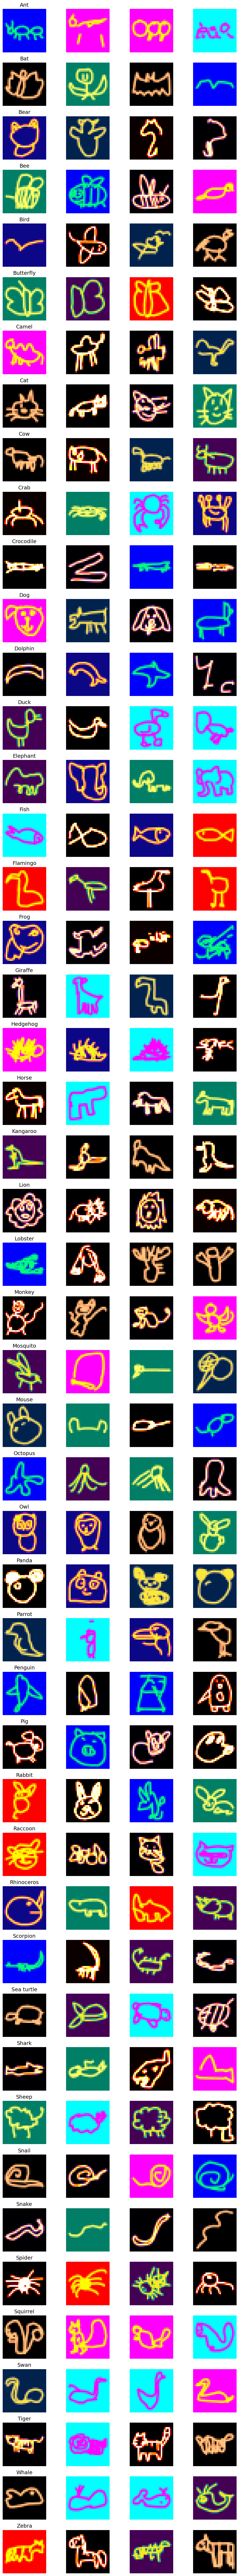

In [43]:
# List of colormaps for variety
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
             'spring', 'summer', 'autumn', 'winter', 'cool',
             'hot', 'afmhot', 'gist_heat', 'copper']

# Function to load data from a .npy file
def load_data(category):
    filename = os.path.join(data_dir, f'{category}.npy')
    data = np.load(filename)
    return data

# subplot set up
num_categories = len(animal_categories)
images_per_category = 4  # Number of images to display per category
total_rows = num_categories

# Create a large figure
fig, axes = plt.subplots(total_rows, images_per_category, figsize=(10, 2 * total_rows))  # 4 columns for each category

for i, category in enumerate(animal_categories):
    data = load_data(category)
    for j in range(images_per_category):
        ax = axes[i, j]
        random_cmap = random.choice(colormaps)  # Select a random colormap
        ax.imshow(data[j].reshape(28, 28), cmap=random_cmap)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'{category.capitalize()}', fontsize=14)

plt.tight_layout()

# Save
save_dir = base_data_dir
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'all_category_sketches_random_colors.png')
plt.savefig(save_path)

plt.show()

plt.close(fig)


1. **Visualizing Quick, Draw! Data**: It loads and displays a set of sketches from the Quick, Draw! dataset, specifically focusing on various animal categories.

2. **Applying Color Variety**: For visual diversity, each sketch is displayed using a randomly chosen color scheme from a predefined list of colormaps.

3. **Organizing and Labeling Sketches**: The sketches are organized in a grid layout where each row represents a different animal category. The first sketch in each row is labeled with the name of the animal.

4. **Saving the Visualization**: After arranging and displaying the sketches, the entire set of images is saved as a single file. This allows for easy reference and sharing of the visualized data.

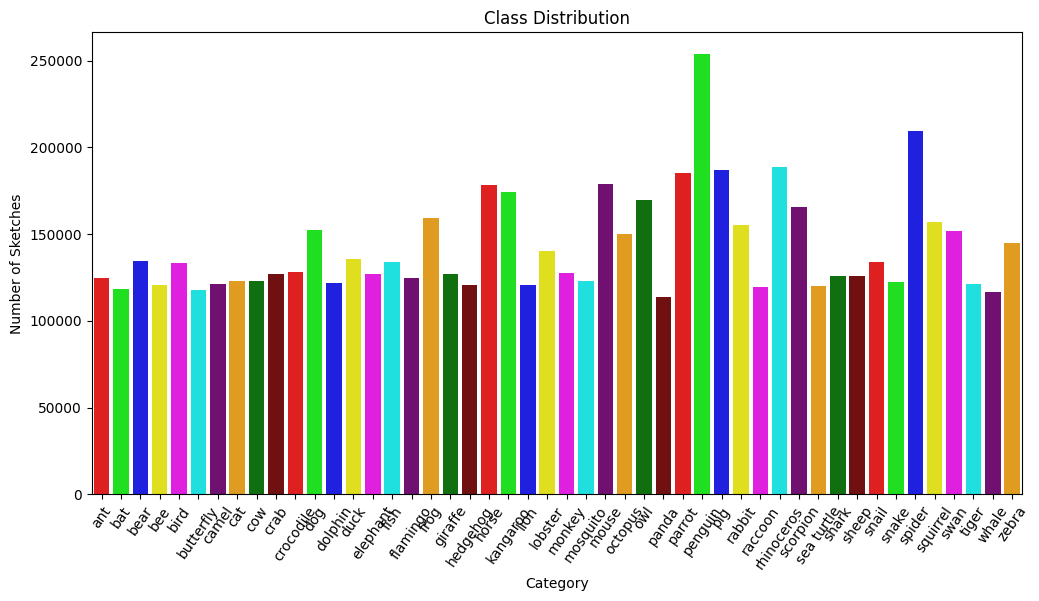

In [39]:
def load_data(category):
    filename = os.path.join(data_dir, f'{category}.npy')
    data = np.load(filename)
    return data

# Analyze class distribution
class_counts = {}
for category in animal_categories:
    data = load_data(category)
    class_counts[category] = len(data)

contrasting_colors = [
    "#FF0000", # Red
    "#00FF00", # Green
    "#0000FF", # Blue
    "#FFFF00", # Yellow
    "#FF00FF", # Magenta
    "#00FFFF", # Cyan
    "#800080", # Purple
    "#FFA500", # Orange
    "#008000", # Dark Green
    "#800000", # Maroon
]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=contrasting_colors[:len(class_counts)])
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Sketches')
plt.xticks(rotation=55)  # Rotate x-axis labels

save_dir = base_data_dir  # Specify your save directory
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'class_distribution_plot.png')
plt.savefig(save_path)

plt.show()
plt.close()

1. **Loading Data**: It defines a function to load data for each animal category from `.npy` files located in a specified directory.

2. **Analyzing Class Distribution**: The code calculates the number of sketches available for each animal category in the dataset, giving insight into the class distribution within the dataset.

3. **Creating a Bar Chart**: It then creates a bar chart to visually represent the class distribution. Each category (animal type) is represented on the x-axis, and the corresponding number of sketches (class count) is represented on the y-axis.

4. **Color Customization**: The bars in the chart are colored using a manually defined set of contrasting colors to enhance visual clarity and differentiation between categories.

5. **Adjusting Visualization**: The chart is appropriately sized and the x-axis labels are rotated for better readability.

6. **Saving the Visualization**: The created bar chart is saved as an image file in a specified directory, allowing for easy storage and future reference.

7. **Displaying and Closing the Plot**: The plot is displayed in the notebook (if applicable) and then closed to free up memory resources.

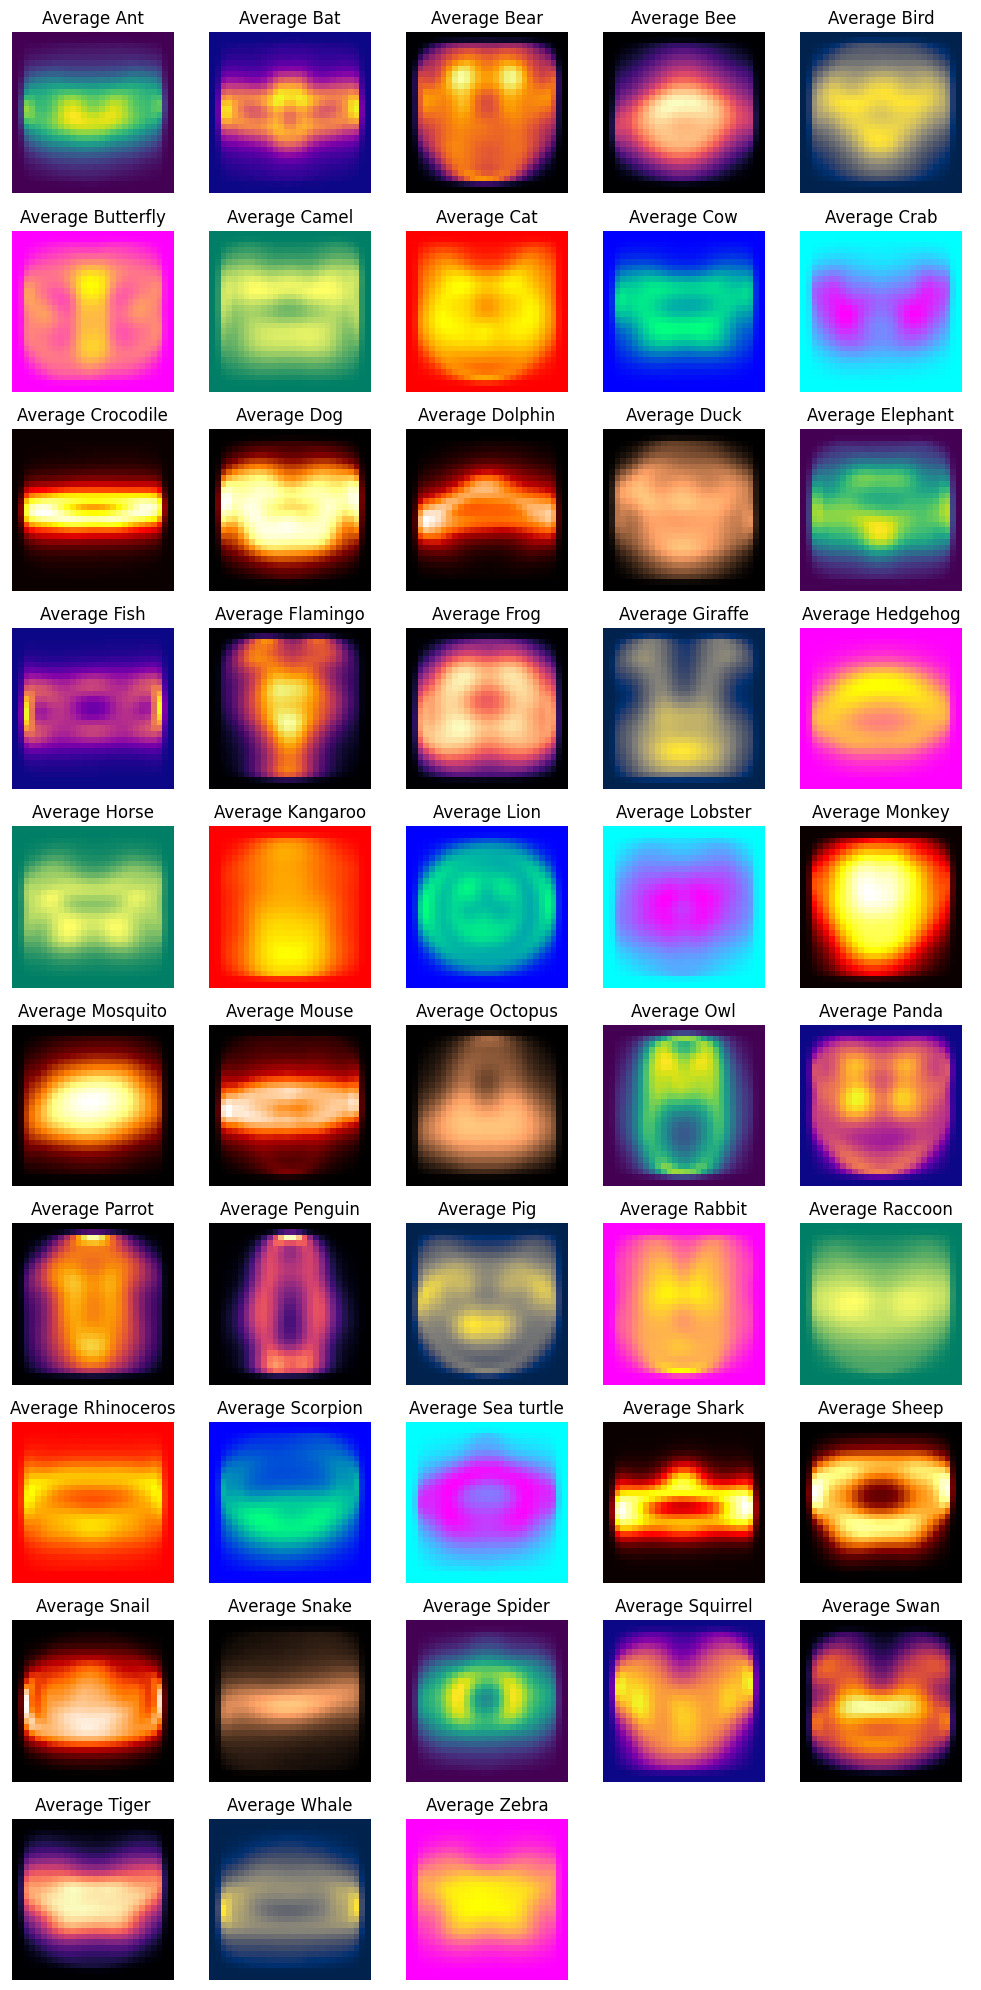

In [38]:
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
             'spring', 'summer', 'autumn', 'winter', 'cool',
             'hot', 'afmhot', 'gist_heat', 'copper']

def load_data(category):
    filename = os.path.join(data_dir, f'{category}.npy')
    data = np.load(filename)
    return data

# Function to compute the average sketch
def compute_average_sketch(data):
    return np.mean(data, axis=0)

# Calculate grid size for subplots
num_categories = len(animal_categories)
num_cols = 5
num_rows = (num_categories + num_cols - 1) // num_cols  # Ceiling division

# Create a large figure (adjust figsize as needed)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))

for i, category in enumerate(animal_categories):
    data = load_data(category)
    avg_sketch = compute_average_sketch(data)
    cmap = colormaps[i % len(colormaps)]  # Cycle through colormaps

    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(avg_sketch.reshape(28, 28), cmap=cmap)
    ax.axis('off')
    ax.set_title(f'Average {category.capitalize()}')

# Turn off any extra axes
for i in range(num_categories, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')


plt.tight_layout()
save_dir = base_data_dir
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'average_sketches_plot.png')
plt.savefig(save_path)

plt.show()
plt.close(fig)

- **Purpose**: This code visualizes the average sketch for each animal category in the dataset, providing an overview of typical features and shapes for each category.

- **Utility**: This visualization provides a quick, composite view of what the typical drawing looks like for each animal category in the dataset. It is useful for understanding the general characteristics of the data and for identifying potential anomalies or biases in how different animals are drawn. This can be especially helpful in preliminary data exploration and in preparing data for machine learning tasks like classification.

## Model Selection and Tuning

Our approach to building a classifier involves using Convolutional Neural Networks (CNNs), a class of deep neural networks highly effective for image classification tasks.

In [11]:
# modify Load data for efficient memory useage
def load_data_efficient(category, data_dir, num_samples=10000):
    filename = os.path.join(data_dir, f'{category}.npy')
    data = np.load(filename)[:num_samples]
    return data

In [12]:
X = []
y = []

In [13]:
for i, category in enumerate(animal_categories):
    data = load_data_efficient(category, data_dir)
    X.extend(data)
    y.extend([i] * len(data))

In [14]:
X = np.array(X).reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Normalize and reshape
y = to_categorical(y, num_classes=len(animal_categories))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Purpose**: The code snippet efficiently loads a subset of drawing data for each animal category and prepares it for training a machine learning model.

- **Efficient Data Loading**: The function `load_data_efficient` is designed to load only a specified number of samples (default 10,000) from each `.npy` file to manage memory usage effectively.

- **Data Directory and Filenames**: It constructs the file path for each category's data file located in the specified `data_dir`.

- **Data Aggregation**: The script iterates over each animal category, loading the data, and appends it to a list `X`. Correspondingly, it generates labels (`y`) for these images, where each category is represented by a unique integer.

- **Normalization and Reshaping**: The data in `X` is converted to a NumPy array, normalized (pixel values divided by 255 to scale between 0 and 1), and reshaped to fit the input requirements of neural networks (here, reshaped to 28x28x1 for each image).

- **One-Hot Encoding of Labels**: The labels in `y` are converted to one-hot encoded vectors to be used in classification tasks, making them suitable for categorical cross-entropy loss functions in neural networks.

- **Data Splitting**: The dataset is split into training and testing sets using the `train_test_split` function, with 20% of the data reserved for testing. This is essential for evaluating the model's performance on unseen data.

- **Random State for Reproducibility**: The `random_state` parameter is set to ensure reproducibility of results. This means the split will be the same every time the code is run, which is helpful for consistent evaluation and comparison of models.

### Initial Model Building

We start by constructing a basic CNN model:

In [ ]:
def build_model(conv_filters, dense_neurons, dropout_rate):
    model = Sequential([
        Conv2D(conv_filters, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(2, 2),
        Conv2D(conv_filters * 2, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(dense_neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(animal_categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

- **Function Overview**: `build_model` creates a CNN model for image classification.

- **Structure**: Includes two convolutional layers with ReLU activation, followed by max-pooling layers.

- **Input Shape**: Expects 28x28 pixel images with one color channel.

- **Feature Processing**: Flattens 2D feature maps to 1D and employs a fully connected dense layer.

- **Dropout**: Incorporates dropout for regularization to prevent overfitting.

- **Output Layer**: Uses a dense layer with softmax activation for class probability output.

- **Customization**: Allows adjustable parameters for convolutional filters, dense layer neurons, and dropout rate.

- **Compilation**: Compiled with Adam optimizer and categorical cross-entropy loss, focusing on classification accuracy.

### Hyperparameter Tuning

To enhance the model's performance, we experiment with various hyperparameters:

In [16]:
# Hyperparameters to tune
conv_filters_options = [32, 64]
dense_neurons_options = [128, 256]
dropout_rate_options = [0.5, 0.6]

best_accuracy = 0
best_hyperparameters = {}

# Iterate through hyperparameters
for conv_filters in conv_filters_options:
    for dense_neurons in dense_neurons_options:
        for dropout_rate in dropout_rate_options:
            print(f"Training with {conv_filters} conv_filters, {dense_neurons} dense_neurons, {dropout_rate} dropout_rate")

            # Build and train the model
            model = build_model(conv_filters, dense_neurons, dropout_rate)
            history = model.fit(X_train, y_train, epochs=3, validation_split=0.2)  # Reduced epochs for tuning

            # Evaluate on validation set
            val_accuracy = max(history.history['val_accuracy'])

            # Update best hyperparameters
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = {'conv_filters': conv_filters, 'dense_neurons': dense_neurons, 'dropout_rate': dropout_rate}

print("Best Hyperparameters:")
print(best_hyperparameters)

Training with 32 conv_filters, 128 dense_neurons, 0.5 dropout_rate
Epoch 1/3
9600/9600 [==============================] - 84s 9ms/step - loss: 2.2446 - accuracy: 0.4046 - val_loss: 1.5667 - val_accuracy: 0.5788
Epoch 2/3
9600/9600 [==============================] - 82s 9ms/step - loss: 1.8186 - accuracy: 0.5119 - val_loss: 1.4334 - val_accuracy: 0.6126
Epoch 3/3
9600/9600 [==============================] - 82s 9ms/step - loss: 1.7047 - accuracy: 0.5400 - val_loss: 1.3852 - val_accuracy: 0.6267
Training with 32 conv_filters, 128 dense_neurons, 0.6 dropout_rate
Epoch 1/3
9600/9600 [==============================] - 83s 9ms/step - loss: 2.4285 - accuracy: 0.3564 - val_loss: 1.6914 - val_accuracy: 0.5527
Epoch 2/3
9600/9600 [==============================] - 81s 8ms/step - loss: 2.0287 - accuracy: 0.4569 - val_loss: 1.5557 - val_accuracy: 0.5872
Epoch 3/3
9600/9600 [==============================] - 82s 9ms/step - loss: 1.8993 - accuracy: 0.4903 - val_loss: 1.4701 - val_accuracy: 0.6087
Tr

- **Hyperparameter Options**: Sets options for convolutional filters (`32`, `64`), dense layer neurons (`128`, `256`), and dropout rates (`0.5`, `0.6`).

- **Initial Best Accuracy**: Starts with a baseline best accuracy of `0` for comparison.

- **Iterative Training**: Loops through all combinations of hyperparameters, training a model for each combination.

- **Model Training**: Each model is built using the `build_model` function and trained on training data (`X_train`, `y_train`) for `3` epochs with a `20%` validation split.

- **Validation Accuracy Assessment**: After each training, the highest validation accuracy is recorded.

- **Best Hyperparameters Determination**: Compares each model's validation accuracy with the current best accuracy and updates the best hyperparameters if a higher accuracy is found.

- **Output**: Prints the best hyperparameters found through this tuning process.

### Model Training and Evaluation

With the best hyperparameters identified, we train the final model and evaluate its performance:

In [ ]:
# Train the final model with the best hyperparameters
final_model = build_model(**best_hyperparameters)
final_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the final model
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Final model test accuracy: {test_accuracy}")

The code above trains the final model using the identified best hyperparameters for 10 epochs, evaluates its performance on the test dataset, and prints the final model's test accuracy.

### Accuracy Over Epochs

Plotting the training and validation accuracy over epochs gives insight into how well the model learned during the training process.

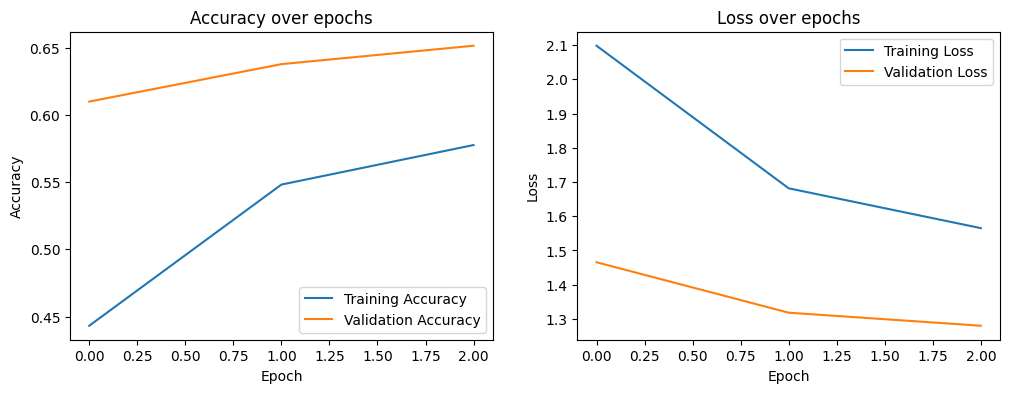

In [36]:
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


save_path = base_data_dir + '/' + 'training_history.png'
plt.savefig(save_path, bbox_inches='tight')
plt.show()

1. **Training and Validation Accuracy**:
   - **Left Graph**: Shows the model's accuracy on the training set (labelled "Training Accuracy") and on the validation set (labelled "Validation Accuracy") over the epochs.
   - Purpose: To track how well the model is learning and generalizing over time. Ideally, both training and validation accuracy should increase with epochs, indicating better learning and generalization.

2. **Training and Validation Loss**:
   - **Right Graph**: Displays the model's loss on the training set (labelled "Training Loss") and on the validation set (labelled "Validation Loss") over the epochs.
   - Purpose: To monitor the model's error or loss as training progresses. Ideally, both training and validation loss should decrease with epochs, indicating that the model is effectively learning and improving its predictions.

### Misclassification Analysis

We further analyze the instances where the model misclassified images, which helps in understanding its limitations.

In [26]:
predictions = model.predict(X_test)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Convert actual labels to class indices if they are one-hot encoded
actual_classes = np.argmax(y_test, axis=1)

# Find the indices of misclassified images
misclassified_indices = np.where(predicted_classes != actual_classes)[0]

3000/3000 [==============================] - 12s 4ms/step


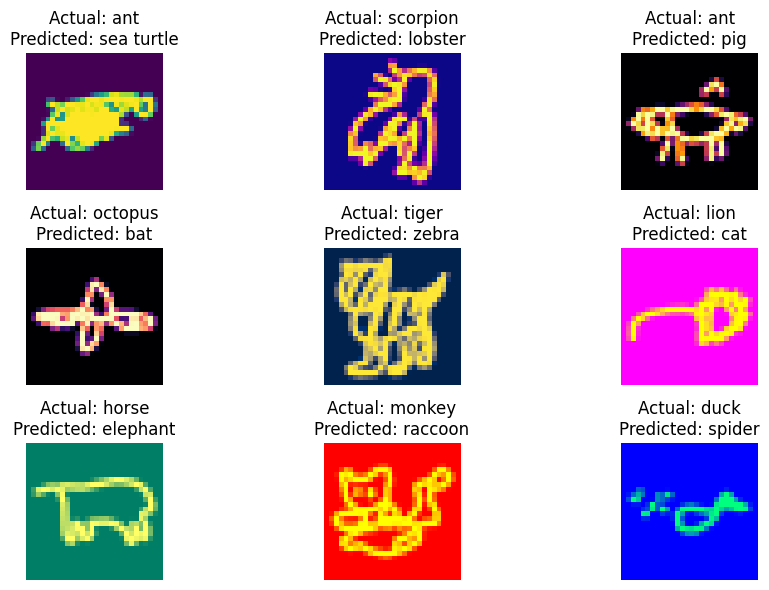

In [35]:
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
             'spring', 'summer', 'autumn', 'winter', 'cool',
             'hot', 'afmhot', 'gist_heat', 'copper']

# Define function to map class indices to class names
def class_name(index):
    return animal_categories[index]

# Function to display misclassified images with varied colormaps
def display_misclassified(indices, num_per_row=3, save_filename=None):
    num_examples = len(indices)
    num_rows = (num_examples + num_per_row - 1) // num_per_row

    plt.figure(figsize=(10, 2 * num_rows))
    for i, idx in enumerate(indices):
        cmap = colormaps[i % len(colormaps)]  # Cycle through colormaps
        plt.subplot(num_rows, num_per_row, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap=cmap)
        plt.title(f"Actual: {class_name(actual_classes[idx])}\nPredicted: {class_name(predicted_classes[idx])}")
        plt.axis('off')

    plt.tight_layout()

    if save_filename:
        plt.savefig(save_filename, bbox_inches='tight')

    plt.show()

# Call the function with a filename to save the image
save_path = base_data_dir + '/' + 'example_misclassified_images.png'
display_misclassified(misclassified_indices[:num_examples_to_display], save_filename=save_path)

This graph visually illustrates examples of misclassified images from the test set, showing each image with its actual and predicted class labels, and uses a variety of colormaps for visual diversity.

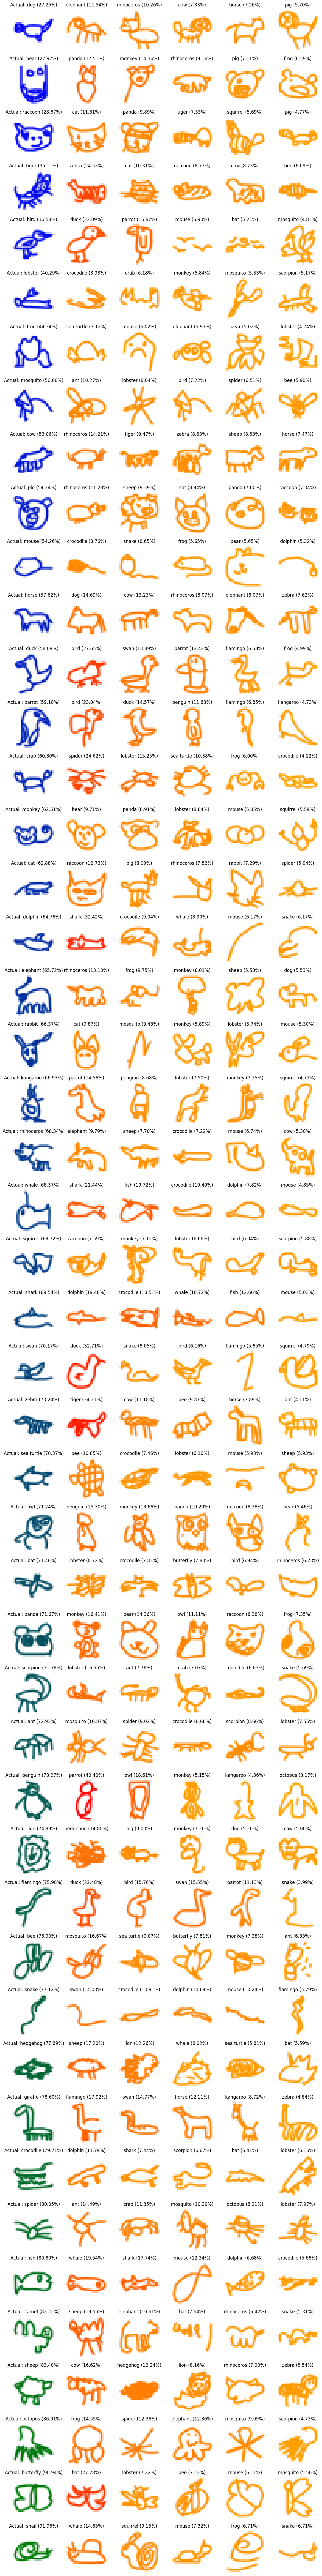

In [30]:
# Create a custom colormap transitioning from blue to green for actual images
colors = ["blue", "green"]
nodes = [0.0, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("bluegreen", list(zip(nodes, colors)))

# Function to overlay semi-transparent color on grayscale image
def apply_colormap(image, color):
    colored_image = np.zeros((*image.shape, 4))  # Create an RGBA image
    colored_image[..., :3] = color[:3]  # Apply RGB values
    colored_image[..., 3] = image  # Use grayscale image as alpha channel
    return colored_image

# Function to generate a color based on misclassification percentage
def get_color_from_percentage(percentage, max_percentage, min_percentage):
    # Interpolate between red (1, 0, 0) and orange (1, 0.65, 0)
    red = 1
    green = 0.65 * (1 - (percentage - min_percentage) / (max_percentage - min_percentage))
    blue = 0
    return (red, green, blue)

# Calculate the accuracy and misclassification counts for each category
accuracy_per_category = {}
misclassified_counts_per_category = {}

for i, category in enumerate(animal_categories):
    actual_indices = np.where(actual_classes == i)[0]
    correct_predictions = np.sum(predicted_classes[actual_indices] == i)
    accuracy_per_category[category] = correct_predictions / len(actual_indices)

    misclassified_indices_this_category = misclassified_indices[np.where(actual_classes[misclassified_indices] == i)]
    misclassified_counts = np.bincount(predicted_classes[misclassified_indices_this_category], minlength=len(animal_categories))
    misclassified_counts[i] = 0  # Exclude correct classifications
    misclassified_counts_per_category[category] = misclassified_counts

# Rank categories by accuracy
ranked_categories = sorted(accuracy_per_category, key=accuracy_per_category.get)

# Determine the max and min misclassification percentages across all categories
all_percentages = [misclassified_counts_per_category[cat][top_misclassified] / np.sum(misclassified_counts_per_category[cat])
                   for cat in ranked_categories for top_misclassified in np.argsort(-misclassified_counts_per_category[cat])[:5]]
max_percentage = max(all_percentages)
min_percentage = min(all_percentages)

# Determine the total number of subplots needed
total_categories = len(ranked_categories)
subplots_per_category = 6  # 1 for actual image + 5 for misclassified images

# Create a large figure (adjust figsize as needed)
fig, axes = plt.subplots(total_categories, subplots_per_category, figsize=(2 * subplots_per_category, 2 * total_categories))

for idx, category in enumerate(ranked_categories):
    actual_indices = np.where(actual_classes == animal_categories.index(category))[0]
    actual_image_index = random.choice(actual_indices)
    color_idx = idx / len(ranked_categories)
    color = custom_cmap(color_idx)
    accuracy = accuracy_per_category[category] * 100
    grayscale_image = X_test[actual_image_index].reshape(28, 28)
    colored_image = apply_colormap(grayscale_image, color)
    axes[idx, 0].imshow(colored_image)
    axes[idx, 0].set_title(f'Actual: {category} ({accuracy:.2f}%)')
    axes[idx, 0].axis('off')

    top_misclassified = np.argsort(-misclassified_counts_per_category[category])[:5]
    for i, misclassified_index in enumerate(top_misclassified):
        misclassified_indices_category = np.where((actual_classes == animal_categories.index(category)) &
                                                  (predicted_classes == misclassified_index))[0]
        if len(misclassified_indices_category) > 0:
            misclassified_image_index = random.choice(misclassified_indices_category)
            scale = misclassified_counts_per_category[category][misclassified_index] / np.sum(misclassified_counts_per_category[category])
            color = get_color_from_percentage(scale, max_percentage, min_percentage)
            colored_image = apply_colormap(X_test[misclassified_image_index].reshape(28, 28), color)
            axes[idx, i + 1].imshow(colored_image)
            axes[idx, i + 1].set_title(f'{animal_categories[misclassified_index]} ({scale * 100:.2f}%)')
            axes[idx, i + 1].axis('off')


plt.tight_layout()
save_dir = base_data_dir
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'classification_plot.png')
plt.savefig(save_path)
plt.show()
plt.close(fig)

1. **Custom Colormap Creation**: It creates a custom colormap that transitions from blue to green. This colormap is used to colorize images based on their category rank in terms of classification accuracy.

2. **Color Overlay Function**: A function `apply_colormap` overlays a semi-transparent color on grayscale images. This function creates an RGBA image where the RGB values are set by the color parameter, and the alpha channel (transparency) is determined by the grayscale image.

3. **Color Generation Based on Misclassification Percentage**: The `get_color_from_percentage` function generates a color based on a given percentage. It interpolates between red (for higher percentages) and orange (for lower percentages).

4. **Accuracy and Misclassification Counts Calculation**: For each animal category, the code calculates the classification accuracy and counts the misclassifications. It then ranks the categories by accuracy.

5. **Visualization of Results**: The code sets up a large figure with subplots for each category. Each row in the figure corresponds to a category, with the first subplot showing an actual image from the test set (colored by the custom colormap) and its classification accuracy. The next subplots show the top 5 misclassified images for that category, colored based on their misclassification percentages.

## Conclusion

### Model and Hyperparameters

In this exploration of classifying animal sketches from the Quick, Draw! dataset, is employed a Convolutional Neural Network (CNN) model, known for its effectiveness in image recognition tasks. The model's architecture included convolutional layers for feature extraction, max pooling layers for dimensionality reduction, and dense layers for classification. The fine-tuning of hyperparameters was a critical part of optimizing our model's performance. There is expermintation with different combinations of convolutional filters, dense neurons, and dropout rates. The final choice of hyperparameters was determined based on their ability to maximize validation accuracy, resulting in a balanced model that efficiently learns from the training data without overfitting.

### Model Performance

The model achieved a moderate accuracy of approximately 68%, which is a commendable performance given the complexity and variability inherent in the Quick, Draw! dataset. This accuracy level indicates that the model has a reasonable ability to recognize and classify different animal sketches, although there is room for improvement.

### Analysis of Misclassified Images

A closer examination of the misclassified sketches revealed insights into the model's limitations and the nature of the data. Many of the misclassifications were such that a human classifier might have made similar mistakes. This observation underscores the inherent challenge in this task – the sketches are drawn by people worldwide, leading to significant variations in style, clarity, and accuracy relative to the intended animal subjects. Some sketches may not closely resemble their intended subjects, making accurate classification challenging even for human observers.


